<a href="https://colab.research.google.com/github/IamVigneshC/Google-AI-solutions/blob/main/ADK_to_Agent_engines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

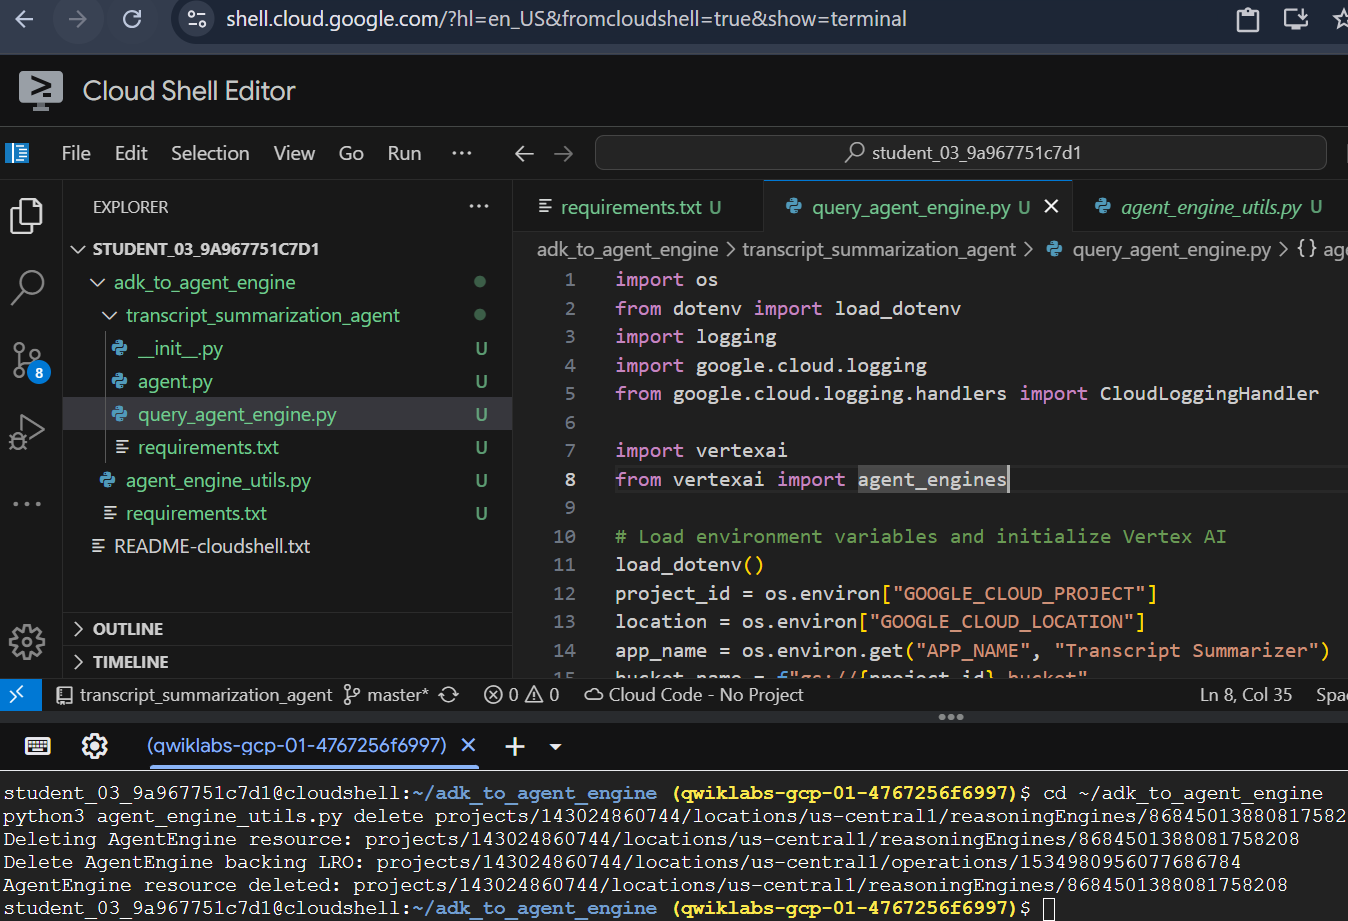

query_agent_engine.py

In [ ]:
import os
from dotenv import load_dotenv
import logging
import google.cloud.logging
from google.cloud.logging.handlers import CloudLoggingHandler

import vertexai
from vertexai import agent_engines

# Load environment variables and initialize Vertex AI
load_dotenv()
project_id = os.environ["GOOGLE_CLOUD_PROJECT"]
location = os.environ["GOOGLE_CLOUD_LOCATION"]
app_name = os.environ.get("APP_NAME", "Transcript Summarizer")
bucket_name = f"gs://{project_id}-bucket"

# Initialize Google Cloud Logging with the correct project ID
cloud_logging_client = google.cloud.logging.Client(project=project_id)
handler = CloudLoggingHandler(cloud_logging_client, name="transcript-summarizer")
logging.getLogger().setLevel(logging.INFO)
logging.getLogger().addHandler(handler)

# Initialize Vertex AI with the correct project and location
vertexai.init(
    project=project_id,
    location=location,
    staging_bucket=bucket_name,
)

# Filter agent engines by the app name in .env
ae_apps = agent_engines.list(filter=f'display_name="{app_name}"')
remote_app = next(ae_apps)

logging.info(f"Using remote app: {remote_app.display_name}")

# Get a session for the remote app
remote_session = remote_app.create_session(user_id="u_456")

transcript_to_summarize = """
    Virtual Agent: Hi, I am a vehicle sales agent. How can I help you?
    User: I'd like to buy a boat.
    Virtual Agent: A big boat, or a small boat?
    User: How much boat will $50,000 get me?
    Virtual Agent: That will get you a very nice boat.
    User: Let's do it!
"""

# Run the agent with this hard-coded input
events = remote_app.stream_query(
    user_id="u_456",
    session_id=remote_session["id"],
    message=transcript_to_summarize,
)

# Print responses
for event in events:
    for part in event["content"]["parts"]:
        if "text" in part:
            response_text = part["text"]
            print("[remote response]", response_text)
            logging.info("[remote response] " + response_text)

cloud_logging_client.flush_handlers()

agent.py

In [ ]:
import os
from dotenv import load_dotenv

from google.adk import Agent

load_dotenv()

root_agent = Agent(
    name="transcript_summarization_agent",
    description="Summarizes chat transcripts.",
    model=os.getenv("MODEL", "gemini-2.5-flash"),
    instruction="Summarize the provided chat transcript.",
)

requirements.txt

In [ ]:
google-cloud-aiplatform[adk,agent_engines]==1.110.0

agent_engine_utils.py

In [ ]:
import os
import fire
from dotenv import load_dotenv
import vertexai
from vertexai import agent_engines

# Load environment variables and initialize Vertex AI
load_dotenv()
vertexai.init(
    project=os.getenv("GOOGLE_CLOUD_PROJECT"),
    location=os.getenv("GOOGLE_CLOUD_LOCATION"),
    staging_bucket="gs://" + os.getenv("GOOGLE_CLOUD_PROJECT") + "-bucket")

# Utility functions for working with Agent Engine
def list():
    """
    List Agent Engine agents.

    Example:
    agent_engine_utils list
    """
    for agent in agent_engines.list():
        print(agent.display_name)
        print(agent.resource_name + "\n")

def delete(resource_name):
    """
    Delete an Agent Engine agent by its resource_name.

    Example:
    agent_engine_utils delete projects/MY_PROJECT_ID/locations/MY_REGION/reasoningEngines/NUMERICAL_ID
    """
    agent_engines.delete(resource_name, force=True)

if __name__ == "__main__":
    fire.Fire()

requirements.txt

In [ ]:
fire==0.7.0
google-cloud-aiplatform[adk,agent_engines]==1.110.0
cloudpickle==3.1.1

.env

In [ ]:
GOOGLE_GENAI_USE_VERTEXAI=TRUE
GOOGLE_CLOUD_PROJECT=qwiklabs-gcp-01-4767256f6997
GOOGLE_CLOUD_LOCATION=us-central1
MODEL=gemini-2.5-flash


Deploy ADK agents to Agent Engine
experiment
Lab
schedule
1 hour 30 minutes
universal_currency_alt
7 Credits
show_chart
Advanced
info
This lab may incorporate AI tools to support your learning.
GENAI107
Google Cloud Self-Paced Labs

Overview
In this lab, you will learn to deploy ADK agents to Agent Engine for a scalable, fully managed environment for your agentic workflows.

This allows you to focus on the agents' logic while infrastructure is allocated and scaled for you.

Objective
In this lab you will learn:

The benefits of deploying agents to Agent Engine
How to grant required roles to the Reasoning Engine Service Agent
How to deploy an agent to Agent Engine using the ADK command line interface
How to query an agent deployed to Agent Engine
How to monitor your deployed agents
How to delete agents
Setup and requirements
Before you click the Start Lab button
Read these instructions. Labs are timed and you cannot pause them. The timer, which starts when you click Start Lab, shows how long Google Cloud resources will be made available to you.

This Qwiklabs hands-on lab lets you do the lab activities yourself in a real cloud environment, not in a simulation or demo environment. It does so by giving you new, temporary credentials that you use to sign in and access Google Cloud for the duration of the lab.

What you need
To complete this lab, you need:

Access to a standard internet browser (Chrome browser recommended).
Time to complete the lab.
Note: If you already have your own personal Google Cloud account or project, do not use it for this lab.

Note: If you are using a Pixelbook, open an Incognito window to run this lab.

How to start your lab and sign in to the Google Cloud console
Click the Start Lab button. If you need to pay for the lab, a dialog opens for you to select your payment method. On the left is the Lab Details pane with the following:

The Open Google Cloud console button
Time remaining
The temporary credentials that you must use for this lab
Other information, if needed, to step through this lab
Click Open Google Cloud console (or right-click and select Open Link in Incognito Window if you are running the Chrome browser).

The lab spins up resources, and then opens another tab that shows the Sign in page.

Tip: Arrange the tabs in separate windows, side-by-side.

Note: If you see the Choose an account dialog, click Use Another Account.
If necessary, copy the Username below and paste it into the Sign in dialog.

student-03-9a967751c7d1@qwiklabs.net
Copied!
You can also find the Username in the Lab Details pane.

Click Next.

Copy the Password below and paste it into the Welcome dialog.

o0O1PdSUVQJZ
Copied!
You can also find the Password in the Lab Details pane.

Click Next.

Important: You must use the credentials the lab provides you. Do not use your Google Cloud account credentials.
Note: Using your own Google Cloud account for this lab may incur extra charges.
Click through the subsequent pages:

Accept the terms and conditions.
Do not add recovery options or two-factor authentication (because this is a temporary account).
Do not sign up for free trials.
After a few moments, the Google Cloud console opens in this tab.

Note: To access Google Cloud products and services, click the Navigation menu or type the service or product name in the Search field. Navigation menu icon and Search field
Agent Engine
Vertex AI Agent Engine (formerly known as LangChain on Vertex AI or Vertex AI Reasoning Engine) is a fully managed Google Cloud service enabling developers to deploy, manage, and scale AI agents in production.

You can learn more about its benefits in the Vertex AI Agent Engine documentation.

Task 1. Install ADK and set up your environment
Note: Using an Incognito browser window is recommended for most Qwiklabs to avoid confusion between your Qwiklabs student account and other accounts logged into Google Cloud. If you are using Chrome, the easiest way to accomplish this is to close any Incognito windows, then right click on the Open Google Cloud console button at the top of this lab and select Open link in Incognito window.
Enable Vertex AI recommended APIs
In this lab environment, the Vertex AI API has been enabled for you. If you were to follow these steps in your own project, you could enable it by navigating to Vertex AI and following the prompt to enable it.
Prepare a Cloud Shell Editor tab
With your Google Cloud console window selected, open Cloud Shell by pressing the G key and then the S key on your keyboard. Alternatively, you can click the Activate Cloud Shell button (Activate Cloud Shell) in the upper right of the Cloud console.

Click Continue.

When prompted to authorize Cloud Shell, click Authorize.

In the upper right corner of the Cloud Shell Terminal panel, click the Open in new window button Open in new window button.

In the Cloud Shell Terminal, enter the following to open the Cloud Shell Editor to your home directory:

cloudshell workspace ~
Copied!
Close any additional tutorial or Gemini panels that appear on the right side of the screen to save more of your window for your code editor.
Throughout the rest of this lab, you can work in this window as your IDE with the Cloud Shell Editor and Cloud Shell Terminal.
Download and install ADK and code samples for this lab
Update your PATH environment variable and install ADK by running the following commands in the Cloud Shell Terminal.

export PATH=$PATH:"/home/${USER}/.local/bin"
python3 -m pip install google-adk
Copied!
Paste the following commands into the Cloud Shell Terminal to copy a file from a Cloud Storage bucket, and unzip it, creating a project directory with code for this lab:

gcloud storage cp -r gs://qwiklabs-gcp-01-4767256f6997-bucket/adk_to_agent_engine .
Copied!
Install additional lab requirements with:

python3 -m pip install -r adk_to_agent_engine/requirements.txt
Copied!
Run the following commands to create a .env file in the adk_to_agent_engine directory. (Note: To view a hidden file beginning with a period, you can use the Cloud Shell Editor menus to enable View > Toggle Hidden Files):

cd ~/adk_to_agent_engine
cat << EOF > .env
GOOGLE_GENAI_USE_VERTEXAI=TRUE
GOOGLE_CLOUD_PROJECT=qwiklabs-gcp-01-4767256f6997
GOOGLE_CLOUD_LOCATION=us-central1
MODEL=gemini-2.5-flash
EOF
Copied!
Copy the .env file to the agent directory to provide your agent necessary authentication configurations once it is deployed:

cp .env transcript_summarization_agent/.env
Copied!
Task 2. Deploy to Agent Engine using the command line deploy method
ADK's command line interface provides shortcuts to deploy agents to Agent Engine, Cloud Run, and Google Kubernetes Engine (GKE). You can use the following base commands to deploy to each of these services:

adk deploy agent_engine (with its command line args described under the @deploy.command("agent_engine") decorator)
adk deploy cloud_run (with its command line args described under the @deploy.command("cloud_run") decorator)
adk deploy gke (with its command line args described under the @deploy.command("gke") decorator)
The adk deploy agent_engine command wraps your agent in a reasoning_engines.AdkApp class and deploys this app to Agent Engine's managed runtime, ready to receive agentic queries.

When an AdkApp is deployed to Agent Engine, it automatically uses a VertexAiSessionService for persistent, managed session state. This provides multi-turn conversational memory without any additional configuration. For local testing, the application defaults to a temporary, InMemorySessionService.

To deploy an Agent Engine app using adk deploy agent_engine, complete the following steps:

In the adk_to_agent_engine/transcript_summarization_agent directory, click on the agent.py file to review the instructions of this simple summarization agent.

To deploy an agent, you must provide its requirements. In Cloud Shell Editor, right-click on the transcript_summarization_agent directory. (You may need to click Allow to enable the right-click menu.)

Select New File...

Name the file like a standard Python requirements file: requirements.txt

Paste the following into the file:

google-cloud-aiplatform[adk,agent_engines]==1.110.0
Copied!
Save the file.

In the Cloud Shell Terminal, run the deploy command:

adk deploy agent_engine transcript_summarization_agent \
--display_name "Transcript Summarizer" \
--staging_bucket gs://qwiklabs-gcp-01-4767256f6997-bucket
Copied!
You can follow the status from the log file that will be linked from the command's output. During deployment, the following steps are occurring:

A bundle of artifacts is generated locally, comprising:
*.pkl: a pickle file corresponding to local_agent.
requirements.txt: this file from the agent folder defining package requirements.
dependencies.tar.gz: a tar file containing any extra packages.
The bundle is uploaded to Cloud Storage (using a defined directory if specified) for staging the artifacts.
The Cloud Storage URIs for the respective artifacts are specified in the PackageSpec.
The Vertex AI Agent Engine service receives the request and builds containers and spins up HTTP servers on the backend.
Note: Deployment should take about 10 minutes, but you can continue with this lab while it deploys.

Quiz While Your Agent is Deploying
Each of the adk deploy ... commands requires certain arguments to be set. For the most up-to-date arguments, click the linked commands in the list at the top of this task and look for the arguments marked as "Required".

Some required arguments, like --project and --region from the adk deploy agent_engine deployment can load their values from the agent's .env file if present.

Answer the following questions based on the arguments for adk deploy agent_engine:


The `--agent_engine_id` argument allows you to update an existing Agent Engine instance.
check
True
False

The `--trace_to_cloud` argument has a default value of True.
close
True
check
False

Which of the following is true about the `--adk_app` argument?
Defaults to use your agent.py file.
close
Creates app files for you to edit.
close
Is required.
check
Accepts a filename to define an ADK app.

Highlights from Expected Output:

Copying agent source code...
Copying agent source code complete.
Initializing Vertex AI...
[...]
Creating AgentEngine
Create AgentEngine backing LRO: projects/430282503153/locations/us-central1/reasoningEngines/2902138951282196480/operations/2777364189918789632
View progress and logs at https://console.cloud.google.com/logs/query?project=qwiklabs-gcp-04-f71a2270bd79
AgentEngine created. Resource name: projects/430282503153/locations/us-central1/reasoningEngines/2902138951282196480
To use this AgentEngine in another session:
agent_engine = vertexai.agent_engines.get('projects/430282503153/locations/us-central1/reasoningEngines/2902138951282196480')
Cleaning up the temp folder: /tmp/agent_engine_deploy_src/20250813_175223
Click Check my progress to verify the objective.
Assessment Completed!
Deploy your agent.
Assessment Completed!

Task 3. Get and query an agent deployed to Agent Engine
To query the agent, you must first grant it the authorization to call models via Vertex AI.

To see the service agent and its assigned role, navigate to IAM in the console.

Click the checkbox to Include Google-provided role grants.

Find the AI Platform Reasoning Engine Service Agent (service-PROJECT_NUMBER@gcp-sa-aiplatform-re.iam.gserviceaccount.com), and click the edit pencil icon in this service agent's row.

Click + Add another role.

In the Select a role field, enter Vertex AI User. If you deploy an agent that uses tools to access other data, you would grant access to those systems to this service agent as well.

Save your changes.

Back in the Cloud Shell Editor, within the adk_to_agent_engine directory, open the file query_agent_engine.py.

Review the code and comments to notice what it is doing.


What does the code in this file do? Select all that apply.
check
Establish a logging client

Create a Cloud Storage client
check
Initialize Vertex AI
check
Load Agent Engine apps, filtering by display name
check
Create a session

Use Gemini to generate a new transcript
check
Query the summarizer agent

Review the transcript passed to the agent, so that you can evaluate if it's generating an adequate summary.

In the Cloud Shell Terminal, run the file from the adk_to_agent_engine directory with:

cd ~/adk_to_agent_engine/transcript_summarization_agent
python3 query_agent_engine.py
Copied!
Example output (yours results may be a little different):

[remote response] The user wants to buy a boat, and after being asked about the size, inquires how much boat $50,000 will purchase. The Virtual Agent responds that $50,000 will get a "very nice boat," to which the user agrees to proceed.
Click Check my progress to verify the objective.
Assessment Completed!
Query an agent.
Assessment Completed!

Task 4. View and delete agents deployed to Agent Engine
When your agent has completed its deployment, return to a browser tab showing the Cloud Console and navigate to Agent Engine by searching for it and selecting it at the top of the Console.

In the Region dropdown, make sure your location for this lab (us-central1) is selected.

You will see your deployed agent's display name. Click on it to enter its monitoring dashboard.

Notice both the Metrics and Session tabs that will each give you insights into how your agent is being used.

When you are ready to delete your agent, select Deployment details from the top of its monitoring dashboard.

Back in your browser tab running the Cloud Shell Terminal, paste the following command, but don't run it yet:

cd ~/adk_to_agent_engine
python3 agent_engine_utils.py delete REPLACE_WITH_AE_ID
Copied!
From the Agent Engine Deployment info panel, copy the Name field, which will have a format like: projects/qwiklabs-gcp-02-76ce2eed15a5/locations/us-central1/reasoningEngines/1467742469964693504.

Return to the Cloud Shell Terminal and replace the end of the command REPLACE_WITH_AE_ID with the resource name you've copied.

Press Return to run the deletion command.

Example Output:

Deleting AgentEngine resource: projects/1029886909158/locations/us-central1/reasoningEngines/1456078850617245696
Delete AgentEngine backing LRO: projects/1029886909158/locations/us-central1/operations/2884525977596067840
AgentEngine resource deleted: projects/1029886909158/locations/us-central1/reasoningEngines/1456078850617245696
In the Cloud Console, return to the Agent Engine dashboard to see that the agent has been deleted.

To view the simple Python SDK code to list and delete agents, view the contents of the file adk_to_agent_engine/agent_engine_utils.py.

